# **Projet NLP: ANALYSE DES SENTIMENTS TWITTER**

Ce didacticiel contient le code complet qui m'a servi pour affiner mon modèle BERT afin d'effectuer une analyse des sentiments sur un ensemble de données en français relatif au sujet en texte brut. En plus de la formation d'un modèle, nous prétraitons le texte dans un format approprié grace à BERT.



*   Nous chargons les données depuis le drive mais vous pouvez le retrouver sur kaggle https://www.kaggle.com/code/houssemayed/camembert-for-french-tweets-classification/input
*   Nous chargons le modèle BERT grace à la bibliothèque Tensorflow Hub celui ci nous servira d'encodeur pour nos séquences de textes
* Nous construirons notre modèle en combinant BERT avec un simple classificateur
*  Nous entrainerons notre modèle
* Nous enregistrerons notre modèle et l'utiliserons pour classifier les phrases selon le sentiment qu'il dégage.









# A propos de BERT

BERTa été un grand succès sur une variété de tâches en PNL (traitement du langage naturel). Ils calculent des représentations vectorielles dans l'espace du langage naturel qui peuvent être utilisés dans des modèles d'apprentissage. La famille de modèles BERT utilise l'architecture de l'encodeur Transformer pour traiter chaque jeton de texte d'entrée dans le contexte complet de tous les jetons avant et après, d'où le nom : *Bidirectional Encoder Representations from Transformers* en français Représentations d'encodeur bidirectionnel de Transformers.

Les modèles BERT sont généralement pré-formés sur un grand corpus de texte, puis affinés pour des tâches spécifiques.

# Commençons 🔽

In [ ]:
#Une dépendance du prétraitement pour les entrées BERT
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
#Les dépendance pour représenter architecture complete du modèle
!apt-get -qq install -y graphviz && pip install pydot

In [ ]:
#C'est de cette bibliothèque que nous allons prendre notre optimiseur AdamW
!pip install -q tf-models-official==2.7.0

On importe les différentes bibliothèques qui nous seront utile

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, classification_report

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
import pandas as pd
import numpy as np

On récupere et importe notre jeu de données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/Colab Notebooks/french_tweets.csv"
df = pd.read_csv(path)

In [ ]:
df

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."
...,...,...
1526719,1,"Oui, cela fonctionne mieux que de l'attendre à..."
1526720,1,Je viens de me réveiller. Ne pas avoir d'école...
1526721,1,Thewdb.com - très cool d'entendre les vieilles...
1526722,1,Êtes-vous prêt pour votre mojo makeover? Deman...


On observe la distribution des données

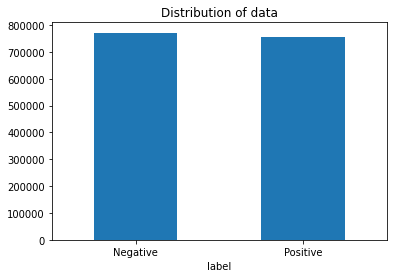

In [ ]:
# Plotting the distribution for dataset.
ax = df.groupby('label').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['label'])

On utilisera uniquement 56000 enregistrements de notre dataset pour des raisons de performances puis on divise notre nouveau jeu de données en trois parti: 20000pour l'entrainement, 30000 pour le test et 6000 pour la validation

In [ ]:
df_neg = df[df["label"]==0]
df_neg = df_neg.iloc[:30000]
df_pos = df[df["label"]==1]
df_pos = df_pos.iloc[:30000]
trainTest_ds_neg = df_neg.iloc[:25000,]
trainTest_ds_pos = df_pos.iloc[5000:,]
trainTest_ds = pd.concat([trainTest_ds_pos, trainTest_ds_neg], ignore_index=True)
val_ds_neg = df_neg.iloc[27000:,]
val_ds_pos = df_pos.iloc[:3000,]
val_ds = pd.concat([val_ds_pos, val_ds_neg], ignore_index=True)
val_ds = val_ds.reindex(columns=['text','label'])
trainTest_ds = trainTest_ds.reindex(columns=['text','label'])
display(trainTest_ds)
display(val_ds)

,text,label
0,Essayant de configurer des canaux de Yahoo pou...,1
1,"J'ai tendance à mordre le dessus, lécher et le...",1
2,J'avais l'habitude de le faire à uni. Je viens...,1
3,"Pas mal mate, continuez bien",1
4,Écrit sur Twitter ..... et espère que tout le ...,1
...,...,...
49995,"Huhu, clickbank ne permet pas aux utilisateurs...",0
49996,J'aurais aimé que je l'avais fait ... mon père...,0
49997,Départ pour troy pour le jour / nuit ... denti...,0
49998,Se sent indubitablement stupide pour avoir lai...,0


,text,label
0,"Je vous aime, les gars sont les meilleurs!",1
1,Je me retrouve avec un de mes besties ce soir!...,1
2,"Merci pour l'ajout de Twitter, sunisa! Je dois...",1
3,Être malade peut être vraiment bon marché quan...,1
4,Il a cet effet sur tout le monde,1
...,...,...
5995,"Lol, homme fou ... hahaha ... monsieur, je vai...",0
5996,Essayant de s'habituer à ce twitter sur lequel...,0
5997,omg ... mon chargeur de batterie Acer Aspire 5...,0
5998,Une autre belle journée. Les oiseaux chantent ...,0


In [ ]:
train_ds, test_ds = train_test_split(trainTest_ds, test_size=0.6, random_state=42, shuffle=True, stratify=trainTest_ds.label)

In [ ]:
train_ds=shuffle(train_ds).reset_index(drop=True)
val_ds=shuffle(val_ds).reset_index(drop=True)
test_ds=shuffle(test_ds).reset_index(drop=True)
train_ds

,text,label
0,C'était génial de vous rencontrer aussi! Je su...,0
1,Ce n'est pas des bombes t-shirts.,0
2,Retour de Grèce ... je veux revenir en arrière,0
3,Whatsapp twitters .....,0
4,En regardant un dernier épisode de docteur qui...,0
...,...,...
19995,Mes cheveux manquent. 5 pouces de ça .... mais...,0
19996,Jour incroyable ... tailgating et journée à bo...,1
19997,Est triste que becca ne va pas au spectacle de...,0
19998,L'amour de ma vie a tourné 23 la semaine derni...,0


In [ ]:
train_ds.groupby('label').count()

,text
label,
0,10000
1,10000


# Chargement du modèle BERT depuis Tensorflow Hub
Ici, nous allons choisir le modèle BERT que nous allons charger à partir de TensorFlow Hub et le régler avec précision. Il existe plusieurs modèles BERT disponibles et consultable à sur https://tfhub.dev/google/collections/bert/1

Etant données qu'on souhaite faire de l'analyse de sentiment dans le contexte francophone la version multi langue de BERT est la mieux adaptée pour nous.https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3

Il utilise L = 12 couches cachées (c'est-à-dire des blocs Transformer), chacune de taille H = 768 et A = 12 têtes d'attention.

Ce SavedModel implémente l'API d'[encodeur pour les incorporations de texte avec des encodeurs de transformateur](https://www.tensorflow.org/hub/common_saved_model_apis/text#transformer-encoders) . Il attend un dict avec trois Tensors int32 en entrée : input_word_ids, input_masket input_type_ids. il existe un préprocesseur séparé SavedModel sur https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3 qui transforme les entrées de texte brut dans ce format, que sa documentation décrit plus en détail.

In [ ]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'

}

map_model_to_preprocess = {
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


# On charge le préprocesseur pour notre modèle BERT

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ["mon frere est content d'avoir reussi son permis"]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 34372 12127 12122 10176 19509   172   112 13508 11639 66148 10116]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


on peut voir que le préprocesseur à transformé le texte brute en une sortie composé des 3 sorties du pré-traitement qu'un modèle BERT utiliserait ( **input_words_id**, **input_masket** **input_type_ids**).

on peut remarqué que le texte à été tronqué en 128 tokens.

# On charge notre modèle BERT

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.23244722 -0.01552258  0.23109005 -0.16374145 -0.12923603  0.2849952
  0.10650096  0.18556643 -0.3099554   0.10125566 -0.099031   -0.15813386]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.1914292   0.25214788  0.00230324 ...  0.12576522 -0.0206904
   0.27026924]
 [ 0.04624162 -0.03727764  0.2897571  ... -0.42949116 -0.40230736
   0.12694988]
 [ 0.18823463  0.07426049  0.30471763 ... -0.2490075  -0.01217503
  -0.58446926]
 ...
 [-0.07925654  0.7625677   0.03774321 ...  0.22441116  0.29442063
   1.0629487 ]
 [ 0.1283312  -0.3975267   1.0085969  ...  0.01865927  0.17951743
   1.2316402 ]
 [-0.071646   -0.0942322   0.7366003  ... -0.17647702 -0.14897206
   1.2332428 ]]


Les modèles BERT retournent une carte avec 3 clés importantes : **pooled_output**, **sequence_output**,**encoder_outputs** :


*   **pooled_output** représente la séquence comme un seul vecteur de taille 768 (*c'est celui que nous allons utiliser*)
*   **sequence_output**  représente chaque jeton d'entrée dans le contexte lexical de la phrase le nombre de jeton étant fixé à 128 par le préprocesseur on obtient une matrice de taille 128 X 768
* **encoder_outputs** sont les activations intermédiaires des L blocs du transformaters.
outputs["encoder_outputs"][i] est un tenseur de la meme forme qu'un sequence_output (c-à-d 128 X 768) avec les sorties du i-ième bloc de transformer, pour 0 <= i < L. La dernière valeur de la liste est égale à *sequence_output*.



# Mise en place du modèle

Nous allons créer ici un modèle affiné très simple, avec le modèle de prétraitement, le modèle BERT sélectionné, une couche Dropout(afin d'eviter un potentiel overfitting) et enfin une couche Dense.

In [ ]:
def build_classifier_model():
    #le texte brute est considéré comme l'entrée du modèle
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    #Dans la couche preprocessing_layer, le text brute est est passé au préprocesseur de BERT qui produit les 3 vecteurs qui seront utilisé par la couche de BERT
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    #la sortie encoder_inputs du modèle de pré-traitement est passé à BERT
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    #une fois les outputs produit on recupère pooled_output qui est une rep globale de notre texte initial
    net = outputs['pooled_output']

    #nous relions le pooled_output à notre couche Dropout
    #(0.1) indique que à chaque étape cette couche met 10% des poids des entrées à zèro àchaque étape de l'entrainement
    net = tf.keras.layers.Dropout(0.1)(net)

    #nous connectons le tout à un simple perceptron(d'où le 1 pour une sortie), la fonction d'activation n'étant pas prise en compte pour l'instant
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

    return tf.keras.Model(text_input, net)

In [ ]:
#Assemblons le tout dans classifier_model
classifier_model = build_classifier_model()

On peut essayer de voir ce qui est produit déjà sans entrainement avec les poids fixées de manière aléatoire. on peut constater plus loin que le résultat n'a pas de sens

In [ ]:
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.47459504]], shape=(1, 1), dtype=float32)


# Nous Visualisons l'architecture complète du modèle

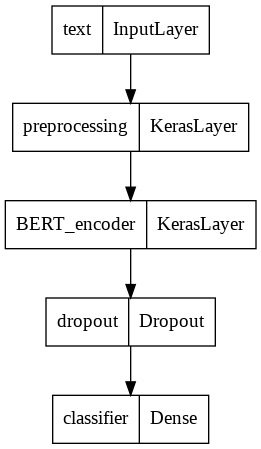

In [ ]:
tf.keras.utils.plot_model(classifier_model)

# Entrainement du modèle

Mettons en place nos métrics d'évaluation du modèle

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

**Optimiseur**

Pour le réglage fin, utilisez le même optimiseur avec lequel BERT a été formé à l'origine : les " Moments adaptatifs " (Adam). Cet optimiseur minimise la perte de prédiction et fait la régularisation par la désintégration de poids (pas en utilisant des moments), qui est également connu sous le nom AdamW .

Pour le taux d'apprentissage ( init_lr ), nous utiliserons la meme démarche que le modèle préformé BERT: décroissance linéaire d'un taux d'apprentissage théorique initiale, préfixé avec une phase d' échauffement linéaire sur la première tranche de 10% des étapes de formation ( num_warmup_steps ). Conformément à l'article du BERT, plus le taux d'apprentissage initial est faible plus le réglage fin (le meilleur de 5e-5, 3e-5, 2e-5).

Nous avons fixé l'entrainement sur 8 epochs et nous utilisons la méthode stochastique pour l'entrainement

In [ ]:
epochs = 8
steps_per_epoch =len(train_ds)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

On compile le tout pour l'entrainement: le modèle, les métriques et l'optimiseur

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

On converti les datasets en des tableaux numpy utilisable plus on effectue l'entrainement

In [ ]:
val_ds = np.array(val_ds)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds.text,
                               y=train_ds.label,
                               validation_data = val_ds.all(),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Epoch 1/8
625/625 [==============================] - 584s 908ms/step - loss: 0.6808 - binary_accuracy: 0.5221
Epoch 2/8
625/625 [==============================] - 568s 909ms/step - loss: 0.5832 - binary_accuracy: 0.6744
Epoch 3/8
625/625 [==============================] - 568s 908ms/step - loss: 0.5158 - binary_accuracy: 0.7369
Epoch 4/8
625/625 [==============================] - 578s 925ms/step - loss: 0.4687 - binary_accuracy: 0.7712
Epoch 5/8
625/625 [==============================] - 567s 907ms/step - loss: 0.4264 - binary_accuracy: 0.7977
Epoch 6/8
625/625 [==============================] - 566s 906ms/step - loss: 0.3817 - binary_accuracy: 0.8264
Epoch 7/8
625/625 [==============================] - 568s 909ms/step - loss: 0.3336 - binary_accuracy: 0.8497
Epoch 8/8
625/625 [==============================] - 567s 908ms/step - loss: 0.2810 - binary_accuracy: 0.8813


L'apprentissage étant terminé, on teste la prédiction faite par le modèle sur la meme phrase dont on a fait le test avant l'entrainement: le valeur obtenue est baeaucoup plus significative

In [ ]:
tf.sigmoid(classifier_model(tf.constant(text_test)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.98940545]], dtype=float32)>

# Evaluation du modèle

On récupere les toutes les prédictions faite sur le jeu de données de test, on fait toute les convertions de datasets nécessaire pour les passer au fonctions d'evaluation

In [ ]:
y_pred = classifier_model.predict(test_ds[:,0])

In [ ]:
test_ds = np.array(test_ds)
test_ds[0][1]=0

In [ ]:
Y_pred= tf.maximum(0,tf.sign(y_pred))
Y_test= tf.convert_to_tensor(test_ds[:,1], dtype=tf.float32)
X_test= tf.convert_to_tensor(test_ds[:,0], dtype=tf.string)

In [ ]:
print(len(y_pred),"; ",len(test_ds[:,1]))

30000 ;  30000


Affichons les metriques d'evaluation et la matrice de confusion

In [ ]:
def model_Evaluate(model):
    # afficher les metriques d'evaluation.
    print(classification_report(Y_test, Y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(Y_test, Y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77     15000
         1.0       0.76      0.80      0.78     15000

    accuracy                           0.78     30000
   macro avg       0.78      0.78      0.78     30000
weighted avg       0.78      0.78      0.78     30000



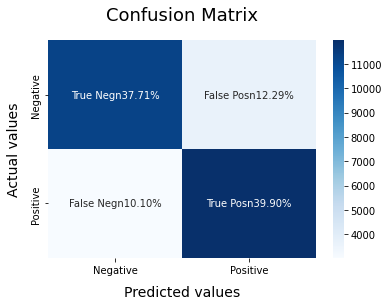

In [ ]:
model_Evaluate(classifier_model)

# Sauvegarde du modèle

In [ ]:
dataset_name = 'AST'
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Verifions que la sauvegarde a été bien effectuée

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
    result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    "C'est le jeudi tout le monde est très beau pour la reunion!",
    "j'ai classe",
    "Ma mère a préparé une nourriture que je n'aime pas trop",
    "C'est le jour de mon anniversaire mais je n'ai reçu aucun cadeau.",
    "C'était aggréable, il y'a eu beaucoup de suspense. on attend la suite..."
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: C'est le jeudi tout le monde est très beau pour la reunion! : score: 0.992422
input: j'ai classe                    : score: 0.559038
input: Ma mère a préparé une nourriture que je n'aime pas trop : score: 0.188428
input: C'est le jour de mon anniversaire mais je n'ai reçu aucun cadeau. : score: 0.025665
input: C'était aggréable, il y'a eu beaucoup de suspense. on attend la suite... : score: 0.904443

Results from the model in memory:
input: C'est le jeudi tout le monde est très beau pour la reunion! : score: 0.992422
input: j'ai classe                    : score: 0.559038
input: Ma mère a préparé une nourriture que je n'aime pas trop : score: 0.188428
input: C'est le jour de mon anniversaire mais je n'ai reçu aucun cadeau. : score: 0.025665
input: C'était aggréable, il y'a eu beaucoup de suspense. on attend la suite... : score: 0.904443



In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: C'est le jeudi tout le monde est très beau pour la reunion! : score: 0.992422
input: j'ai classe                    : score: 0.559038
input: Ma mère a préparé une nourriture que je n'aime pas trop : score: 0.188428
input: C'est le jour de mon anniversaire mais je n'ai reçu aucun cadeau. : score: 0.025665
input: C'était aggréable, il y'a eu beaucoup de suspense. on attend la suite... : score: 0.904443

